# CASA0007 QM Coursework 3

This version explores the moderator and mediator mechanisms, but with variables separately and proceeding only with significant variables.

In [1]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log

## Read and Prepare Variables

### Outcome (O): Well-being

In [2]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
wellbeing_cols = ['Life Satisfaction', 'Worthwhile', 'Happiness']
year = '2011/12'
wellbeing.rename({year: wellbeing_cols[0],
                 year+'.1': wellbeing_cols[1],
                 year+'.2': wellbeing_cols[2],
                 year+'.3': 'Anxiety'},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + wellbeing_cols + ['Anxiety']]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)
wellbeing.drop('Code', axis = 1, inplace = True)

# Set data type
wellbeing[wellbeing_cols + ['Anxiety']] = wellbeing[wellbeing_cols + ['Anxiety']].astype('float', copy = False)

### Stressor (S): Green Cover

In [3]:
# Read NDVI
ndvi_cols = ['lb_code', 'lb_name', 'percent_green']
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover', usecols = ndvi_cols)

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi.sort_values(by = ['lb_name'], ascending=True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

# Rename column
ndvi.drop('lb_name', axis = 1, inplace = True)
ndvi.rename({'lb_code': 'Area'}, axis = 1, inplace = True)

### Control

#### Control 1 (C1): Age + Control 2 (C2): Health

In [4]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health.iloc[i,2] = age_health.iloc[i,2][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+',
           'MSOA Name': 'Area'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad',
              'MSOA Name': 'Area'},
              axis = 1, inplace = True)

#### Control 3 (C3): Economic Activity

In [5]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2011-Dec 2011']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.drop('Code', axis = 1, inplace = True)

# Change data type
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [6]:
# Read unemployment rate
unemployment_cols = ['Code', 'Area', 'Jan 2011-Dec 2011']
unemployment = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'mb-unemployment-rates.xlsx'), 
                             usecols = unemployment_cols, sheet_name = 'Rates')

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
unemployment.dropna(axis = 0, inplace = True)
unemployment = unemployment[unemployment['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
unemployment.drop(unemployment[unemployment.Area == 'City of London'].index, inplace = True)
unemployment = unemployment.reset_index(drop = True)

# Change data type
unemployment['Jan 2011-Dec 2011'] = unemployment['Jan 2011-Dec 2011'].astype('float', copy = False)

In [7]:
# Compute unemployment rate among economically active
economic['Unemployed'] = ((100 - economic.Econ_inactive)/100) * (unemployment['Jan 2011-Dec 2011']/100) * 100

# Compute employment rate among economically active
economic['Employed'] = 100 - economic.Econ_inactive - economic.Unemployed

### Perceived Control

#### Perceived Control 1 (P1): Physical Exercise¶

In [8]:
# Read in physical exercise (from 2012)
exercise = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'LSD21-APS-Physical-Activity-Levels.xlsx'),
                         sheet_name = '2012', usecols = ['GSS_Code', 'Region', 'Active'])

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)
exercise.drop('GSS_Code', axis = 1, inplace = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100

# Rename columns
exercise.rename({'Region': 'Area'}, axis = 1, inplace = True)

#### Perceived Control 2 (P2): Air Quality

In [9]:
# Read in air quality (from 2013)
air_quality = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'NO2_AnnualMean_2013_PopulationData.xlsx'),
                            sheet_name = 'Borough exceeding 40', skiprows = 4, 
                            usecols=['Borough Name', 'PopExc2013 %'])
air_quality['Borough Name'] = air_quality['Borough Name'].str.replace('&', 'and')

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)

# Log
air_quality['log_PopExc2013%'] = air_quality['PopExc2013 %'].apply(log)
air_quality.drop('PopExc2013 %', axis = 1, inplace = True)

# Rename columns
air_quality.rename({'Borough Name': 'Area'},
                  axis = 1, inplace = True)

#### Perceived Control 3 (P3): Anxiety

In [10]:
anxiety = wellbeing.drop(wellbeing_cols, axis = 1)
wellbeing.drop('Anxiety', axis = 1, inplace = True)

## Regression of Outcome (Wellbeing) Against Stressor (Green Cover)

Define functions for scalability

In [11]:
# Define function to extract outliers based on Tukey fences

def re_outliers(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences

    :param df: the pandas dataframe
    :param col_name: the column being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [area] that have been removed
    '''

    # Initialize
    df_clean = df
    outliers_areas = []
    temp_areas = []

    while True:
    
        # Compute quartiles and IQR
        q1 = df_clean[col_name].quantile(0.25)
        q3 = df_clean[col_name].quantile(0.75)
        iqr = q3 - q1
        # Compute Tukey fences
        lo_tukey = q1 - 1.5*iqr
        hi_tukey = q3 + 1.5*iqr
    
        # Locate the rows and areas that are outside the Tukey fences
        outliers_rows = df_clean.index[(df_clean[col_name] < lo_tukey) | (df_clean[col_name] > hi_tukey)]
        
        if len(outliers_rows) > 0:
            temp_areas = df_clean['Area'][outliers_rows].values.tolist()
            outliers_areas = list(set(outliers_areas + temp_areas))
            df_clean = df_clean.drop(index = outliers_rows)
        else:
            break
    
    # Return both cleaned df and outlier areas
    return df_clean, sorted(outliers_areas)

In [12]:
# Define function to remove outliers in paired samples

def re_outliers_paired(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences in paired fashion for multiple columns

    :param df: the pandas dataframe
    :param col_name: the list of column(s) being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''
    # initialize list to hold outlier areas
    outliers_area = []
    
    # For each column
    for col in col_name:
        # get outliers for the column
        temp_df, temp_outliers = re_outliers(df, col)
        # find all unique areas
        outliers_area = list(set(outliers_area + temp_outliers))
    
    outliers_area = sorted(outliers_area)
    
    # For all outlier areas
    df_clean = df
    for i in outliers_area:
        # Drop from df
        df_clean = df_clean.drop(df.index[df['Area'] == i])
    
    return df_clean, outliers_area

In [13]:
# Define function to perform backwards regression using p-value as selection criterion

def back_regress(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

Begin regression

PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.531
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0416
Time:                        23:11:18   Log-Likelihood:                 15.789
No. Observations:                  32   AIC:                            -27.58
Df Residuals:                      30   BIC:                            -24.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

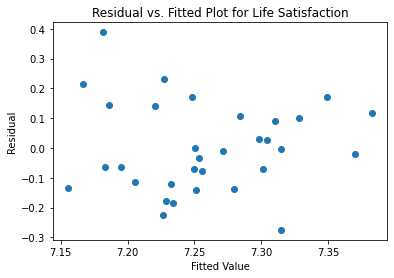



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     13.24
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00102
Time:                        23:11:18   Log-Likelihood:                 17.885
No. Observations:                  32   AIC:                            -31.77
Df Residuals:                      30   BIC:                            -28.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

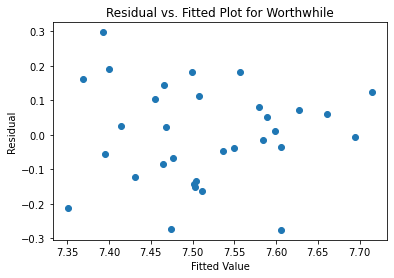



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.822
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0599
Time:                        23:11:18   Log-Likelihood:                 20.486
No. Observations:                  32   AIC:                            -36.97
Df Residuals:                      30   BIC:                            -34.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

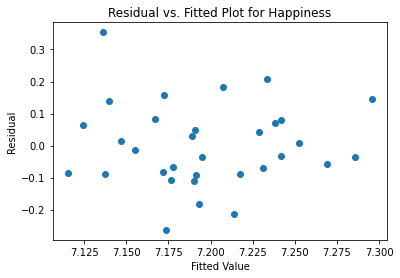

In [20]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')

ind_var = ndvi.columns.tolist()[1:]

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    #reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

Greenery is found to have a statistically significant effect on life satisfaction and worthwhile, but not happiness.

## Regression of Outcome (Wellbeing) Against Control

### Control 1: Age

PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_0-15
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     3.206
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0893
Time:                        23:18:41   Log-Likelihood:                 10.429
No. Observations:                  21   AIC:                            -16.86
Df Residuals:                      19   BIC:                            -14.77
Df Model:                           1                                         
Covariance Type:            nonrobust        

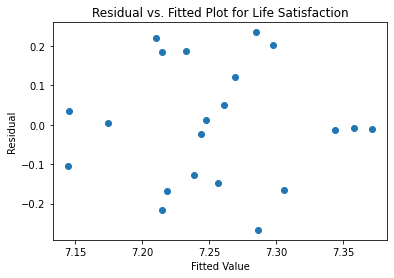



PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_15-29
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     8.649
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00625
Time:                        23:18:41   Log-Likelihood:                 17.592
No. Observations:                  32   AIC:                            -31.18
Df Residuals:                      30   BIC:                            -28.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

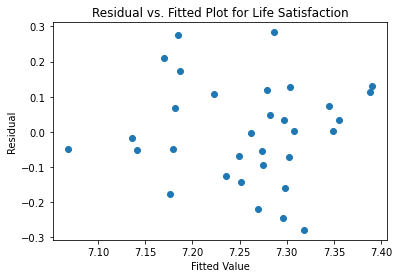



PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_30-44
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6903
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.413
Time:                        23:18:41   Log-Likelihood:                 13.902
No. Observations:                  32   AIC:                            -23.80
Df Residuals:                      30   BIC:                            -20.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

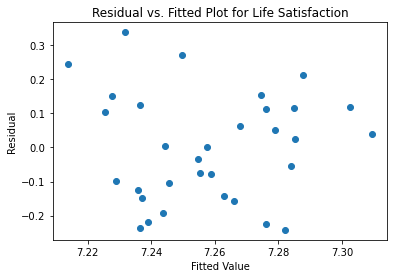



PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_45-64
Outliers: ['Tower Hamlets']
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     9.561
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00436
Time:                        23:18:41   Log-Likelihood:                 18.212
No. Observations:                  31   AIC:                            -32.42
Df Residuals:                      29   BIC:                            -29.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

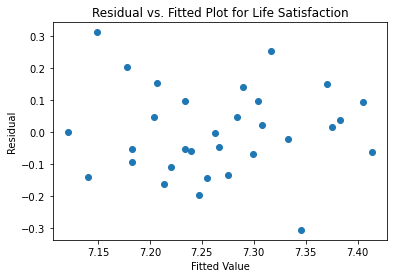



PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_65+
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.39
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000335
Time:                        23:18:41   Log-Likelihood:                 20.511
No. Observations:                  32   AIC:                            -37.02
Df Residuals:                      30   BIC:                            -34.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

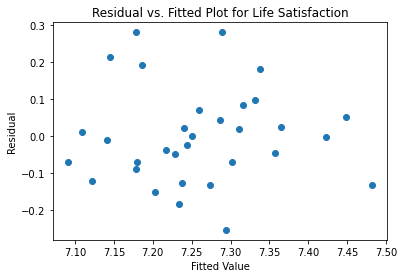



PERFORMING REGRESSION OF WORTHWHILE against AGE_0-15
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.587
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.223
Time:                        23:18:41   Log-Likelihood:                 6.5771
No. Observations:                  21   AIC:                            -9.154
Df Residuals:                      19   BIC:                            -7.065
Df Model:                           1                                         
Covariance Type:            nonrobust             

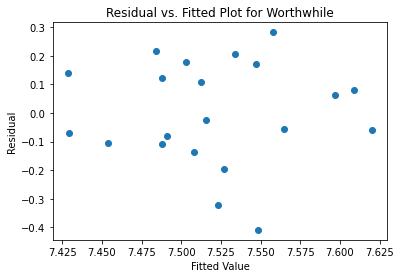



PERFORMING REGRESSION OF WORTHWHILE against AGE_15-29
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     29.08
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           7.69e-06
Time:                        23:18:42   Log-Likelihood:                 22.879
No. Observations:                  32   AIC:                            -41.76
Df Residuals:                      30   BIC:                            -38.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

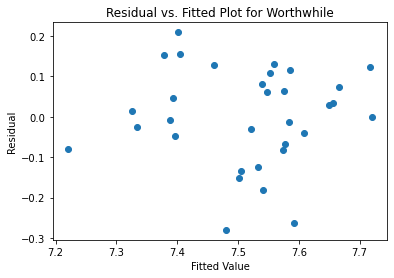



PERFORMING REGRESSION OF WORTHWHILE against AGE_30-44
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.862
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0587
Time:                        23:18:42   Log-Likelihood:                 13.974
No. Observations:                  32   AIC:                            -23.95
Df Residuals:                      30   BIC:                            -21.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

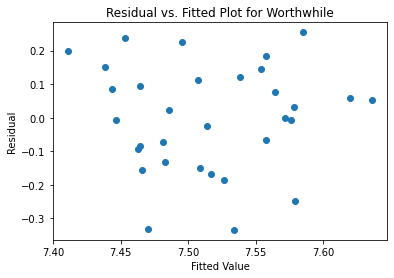



PERFORMING REGRESSION OF WORTHWHILE against AGE_45-64
Outliers: ['Tower Hamlets']
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     20.39
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           9.73e-05
Time:                        23:18:42   Log-Likelihood:                 22.210
No. Observations:                  31   AIC:                            -40.42
Df Residuals:                      29   BIC:                            -37.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

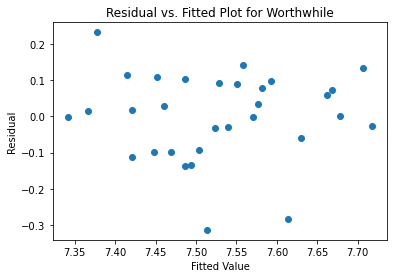



PERFORMING REGRESSION OF WORTHWHILE against AGE_65+
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     27.14
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           1.29e-05
Time:                        23:18:42   Log-Likelihood:                 22.345
No. Observations:                  32   AIC:                            -40.69
Df Residuals:                      30   BIC:                            -37.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

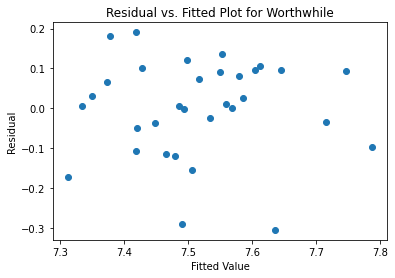



PERFORMING REGRESSION OF HAPPINESS against AGE_0-15
Outliers: ['Barking and Dagenham', 'Camden', 'Enfield', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Newham', 'Redbridge', 'Wandsworth', 'Westminster']
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.7053
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.411
Time:                        23:18:42   Log-Likelihood:                 15.080
No. Observations:                  21   AIC:                            -26.16
Df Residuals:                      19   BIC:                            -24.07
Df Model:                           1                                         
Covariance Type:            nonrobust              

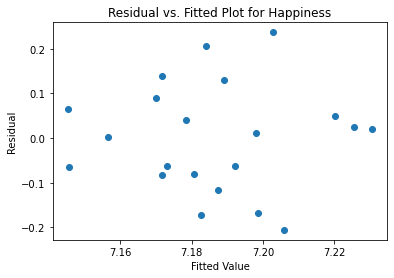



PERFORMING REGRESSION OF HAPPINESS against AGE_15-29
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.642
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.115
Time:                        23:18:42   Log-Likelihood:                 19.918
No. Observations:                  32   AIC:                            -35.84
Df Residuals:                      30   BIC:                            -32.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

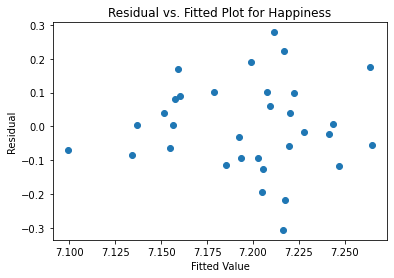



PERFORMING REGRESSION OF HAPPINESS against AGE_30-44
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4092
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.527
Time:                        23:18:43   Log-Likelihood:                 18.784
No. Observations:                  32   AIC:                            -33.57
Df Residuals:                      30   BIC:                            -30.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

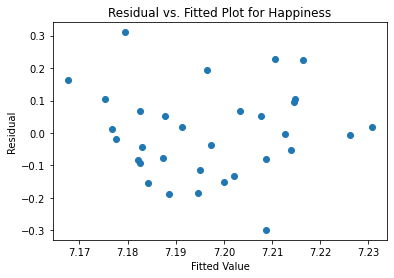



PERFORMING REGRESSION OF HAPPINESS against AGE_45-64
Outliers: ['Tower Hamlets']
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     4.553
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0414
Time:                        23:18:43   Log-Likelihood:                 20.533
No. Observations:                  31   AIC:                            -37.07
Df Residuals:                      29   BIC:                            -34.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

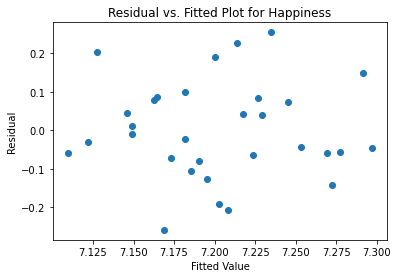



PERFORMING REGRESSION OF HAPPINESS against AGE_65+
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     7.028
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0127
Time:                        23:18:43   Log-Likelihood:                 21.935
No. Observations:                  32   AIC:                            -39.87
Df Residuals:                      30   BIC:                            -36.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

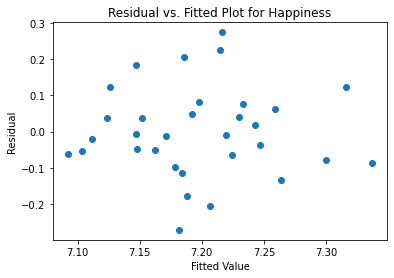

In [24]:
# Merge data
data = pd.merge(wellbeing, age, on = 'Area')

# Groups in control
ind_var = age.columns.tolist()[1:]

# Perform regression
for cat in wellbeing_cols:
    for group in ind_var:
        print(f'PERFORMING REGRESSION OF {cat.upper()} against {group.upper()}')

        # Remove outliers first
        df = data[['Area', cat, group]]
        data_reout, outliers_area = re_outliers_paired(df, [cat, group])
        print('Outliers:', format(outliers_area))

        # Perform regression
        reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[group])).fit()
        #reg_model = back_regress(data_reout[cat], data_reout[group])
        print(reg_model.summary())

        # plot residual vs. fit
        plt.scatter(reg_model.fittedvalues, reg_model.resid)
        plt.xlabel('Fitted Value')
        plt.ylabel('Residual')
        plt.title('Residual vs. Fitted Plot for ' + cat.title())
        plt.show()
        print('\n')

PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_0-15
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.233
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0294
Time:                        23:32:47   Log-Likelihood:                 16.111
No. Observations:                  32   AIC:                            -28.22
Df Residuals:                      30   BIC:                            -25.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

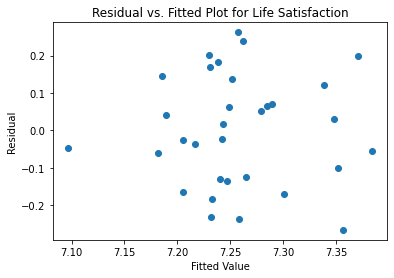



PERFORMING REGRESSION OF LIFE SATISFACTION against AGE_45-64
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     13.01
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00111
Time:                        23:32:47   Log-Likelihood:                 19.304
No. Observations:                  32   AIC:                            -34.61
Df Residuals:                      30   BIC:                            -31.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

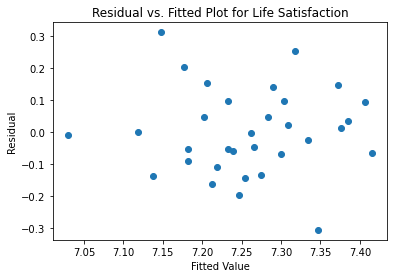



PERFORMING REGRESSION OF WORTHWHILE against AGE_0-15
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2020
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.656
Time:                        23:32:48   Log-Likelihood:                 12.144
No. Observations:                  32   AIC:                            -20.29
Df Residuals:                      30   BIC:                            -17.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

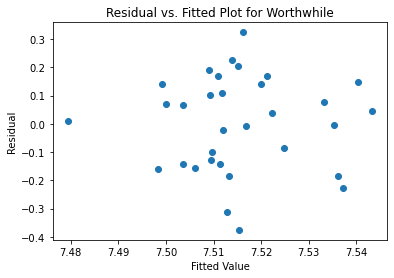



PERFORMING REGRESSION OF WORTHWHILE against AGE_45-64
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     30.35
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           5.53e-06
Time:                        23:32:48   Log-Likelihood:                 23.221
No. Observations:                  32   AIC:                            -42.44
Df Residuals:                      30   BIC:                            -39.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

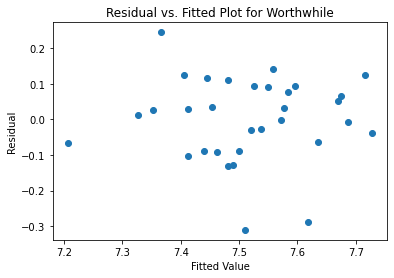



PERFORMING REGRESSION OF HAPPINESS against AGE_0-15
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.798
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0224
Time:                        23:32:48   Log-Likelihood:                 21.394
No. Observations:                  32   AIC:                            -38.79
Df Residuals:                      30   BIC:                            -35.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

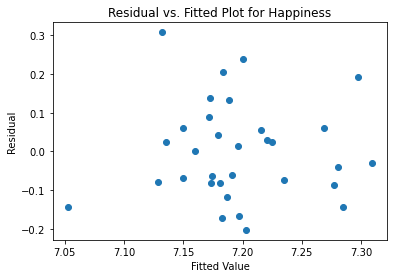



PERFORMING REGRESSION OF HAPPINESS against AGE_45-64
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     6.467
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0164
Time:                        23:32:48   Log-Likelihood:                 21.691
No. Observations:                  32   AIC:                            -39.38
Df Residuals:                      30   BIC:                            -36.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

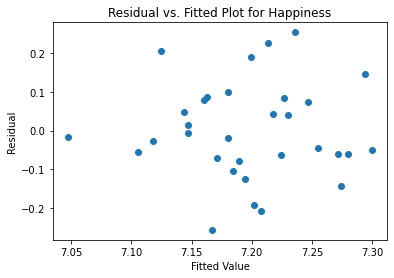

In [26]:
# Check for groups with outliers
ind_var = ['Age_0-15', 'Age_45-64']

# Perform regression
for cat in wellbeing_cols:
    for group in ind_var:
        print(f'PERFORMING REGRESSION OF {cat.upper()} against {group.upper()}')

        # Perform regression
        reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(data[group])).fit()
        #reg_model = back_regress(data[cat], data[group])
        print(reg_model.summary())

        # plot residual vs. fit
        plt.scatter(reg_model.fittedvalues, reg_model.resid)
        plt.xlabel('Fitted Value')
        plt.ylabel('Residual')
        plt.title('Residual vs. Fitted Plot for ' + cat.title())
        plt.show()
        print('\n')

### Control 2: Health

PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST VERY_GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6.543
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0158
Time:                        23:35:37   Log-Likelihood:                 16.695
No. Observations:                  32   AIC:                            -29.39
Df Residuals:                      30   BIC:                            -26.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

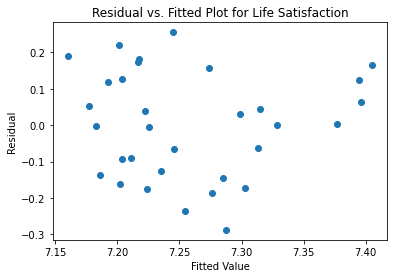



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.615
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.214
Time:                        23:35:37   Log-Likelihood:                 14.378
No. Observations:                  32   AIC:                            -24.76
Df Residuals:                      30   BIC:                            -21.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

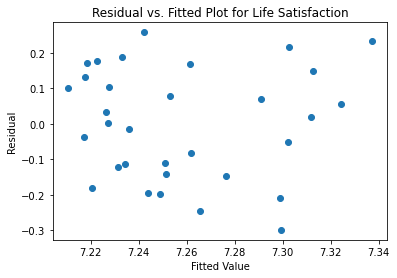



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST FAIR
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.302
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0467
Time:                        23:35:37   Log-Likelihood:                 15.683
No. Observations:                  32   AIC:                            -27.37
Df Residuals:                      30   BIC:                            -24.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

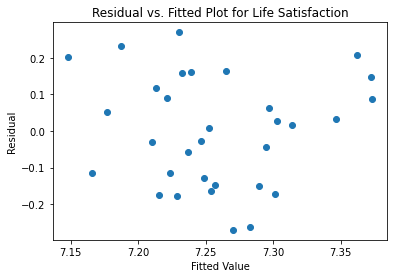



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     22.46
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           4.86e-05
Time:                        23:35:37   Log-Likelihood:                 22.481
No. Observations:                  32   AIC:                            -40.96
Df Residuals:                      30   BIC:                            -38.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

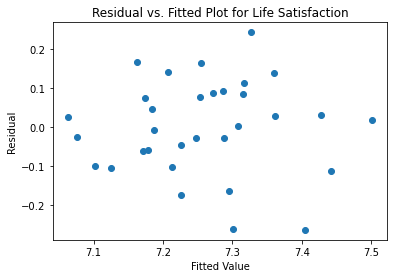



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST VERY_BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     18.66
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000158
Time:                        23:35:37   Log-Likelihood:                 21.276
No. Observations:                  32   AIC:                            -38.55
Df Residuals:                      30   BIC:                            -35.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

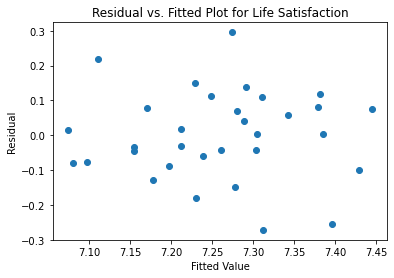



PERFORMING REGRESSION OF WORTHWHILE AGAINST VERY_GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.064
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.310
Time:                        23:35:37   Log-Likelihood:                 12.595
No. Observations:                  32   AIC:                            -21.19
Df Residuals:                      30   BIC:                            -18.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

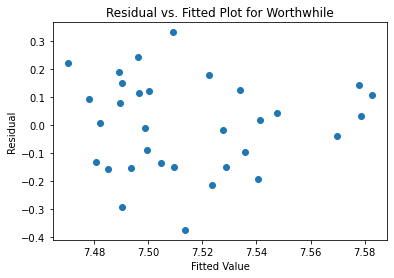



PERFORMING REGRESSION OF WORTHWHILE AGAINST GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                  0.002455
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.961
Time:                        23:35:37   Log-Likelihood:                 12.038
No. Observations:                  32   AIC:                            -20.08
Df Residuals:                      30   BIC:                            -17.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

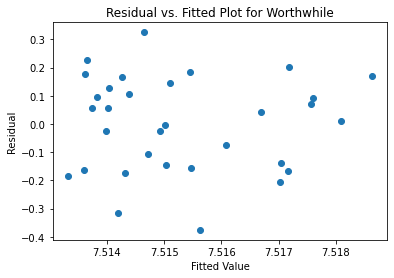



PERFORMING REGRESSION OF WORTHWHILE AGAINST FAIR
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.1826
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.672
Time:                        23:35:38   Log-Likelihood:                 12.134
No. Observations:                  32   AIC:                            -20.27
Df Residuals:                      30   BIC:                            -17.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

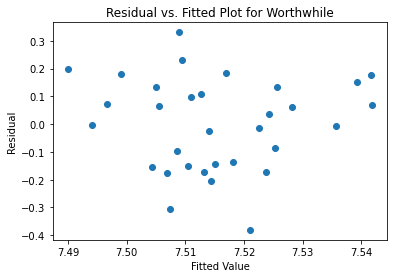



PERFORMING REGRESSION OF WORTHWHILE AGAINST BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     17.54
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000227
Time:                        23:35:38   Log-Likelihood:                 19.404
No. Observations:                  32   AIC:                            -34.81
Df Residuals:                      30   BIC:                            -31.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

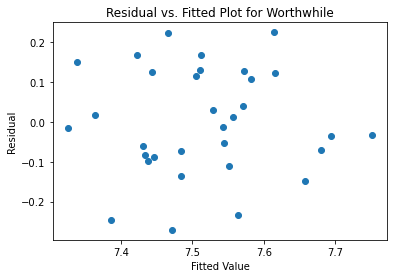



PERFORMING REGRESSION OF WORTHWHILE AGAINST VERY_BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     26.71
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           1.45e-05
Time:                        23:35:38   Log-Likelihood:                 22.226
No. Observations:                  32   AIC:                            -40.45
Df Residuals:                      30   BIC:                            -37.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

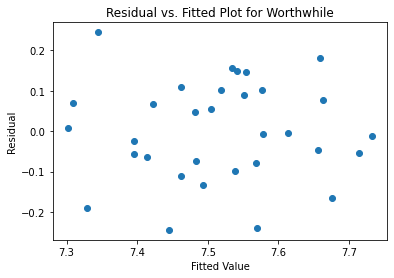



PERFORMING REGRESSION OF HAPPINESS AGAINST VERY_GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.446
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.128
Time:                        23:35:38   Log-Likelihood:                 19.821
No. Observations:                  32   AIC:                            -35.64
Df Residuals:                      30   BIC:                            -32.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

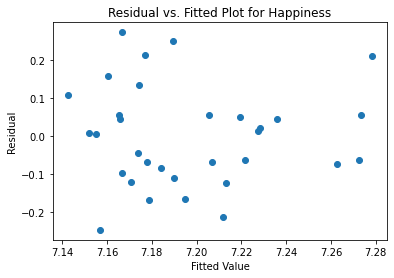



PERFORMING REGRESSION OF HAPPINESS AGAINST GOOD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.5709
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.456
Time:                        23:35:38   Log-Likelihood:                 18.869
No. Observations:                  32   AIC:                            -33.74
Df Residuals:                      30   BIC:                            -30.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

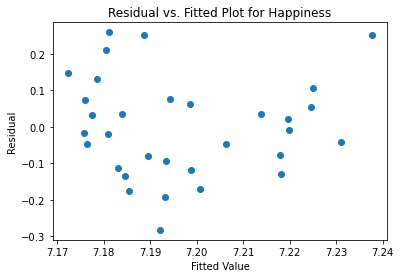



PERFORMING REGRESSION OF HAPPINESS AGAINST FAIR
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.839
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.185
Time:                        23:35:38   Log-Likelihood:                 19.519
No. Observations:                  32   AIC:                            -35.04
Df Residuals:                      30   BIC:                            -32.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

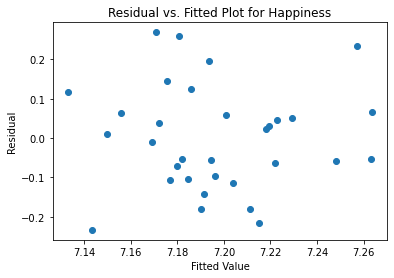



PERFORMING REGRESSION OF HAPPINESS AGAINST BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     7.377
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0109
Time:                        23:35:38   Log-Likelihood:                 22.085
No. Observations:                  32   AIC:                            -40.17
Df Residuals:                      30   BIC:                            -37.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

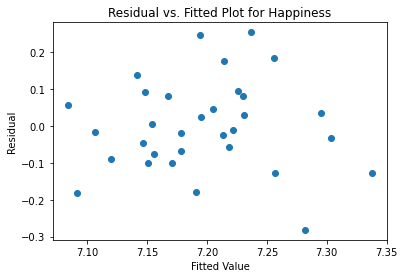



PERFORMING REGRESSION OF HAPPINESS AGAINST VERY_BAD
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     5.681
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0237
Time:                        23:35:39   Log-Likelihood:                 21.342
No. Observations:                  32   AIC:                            -38.68
Df Residuals:                      30   BIC:                            -35.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

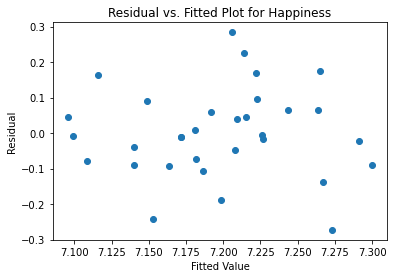

In [28]:
# Merge data
data = pd.merge(wellbeing, health, on = 'Area')

# Groups in control
ind_var = health.columns.tolist()[1:]

# Perform regression
for cat in wellbeing_cols:
    for group in ind_var:
        print(f'PERFORMING REGRESSION OF {cat.upper()} AGAINST {group.upper()}')

        # Remove outliers first
        df = data[['Area', cat, group]]
        data_reout, outliers_area = re_outliers_paired(df, [cat, group])
        print('Outliers:', format(outliers_area))

        # Perform regression
        reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[group])).fit()
        #reg_model = back_regress(data_reout[cat], data_reout[group])
        print(reg_model.summary())

        # plot residual vs. fit
        plt.scatter(reg_model.fittedvalues, reg_model.resid)
        plt.xlabel('Fitted Value')
        plt.ylabel('Residual')
        plt.title('Residual vs. Fitted Plot for ' + cat.title())
        plt.show()
        print('\n')

### Control 3: Economic Activity

PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST ECON_INACTIVE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.221
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.278
Time:                        23:39:34   Log-Likelihood:                 14.177
No. Observations:                  32   AIC:                            -24.35
Df Residuals:                      30   BIC:                            -21.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

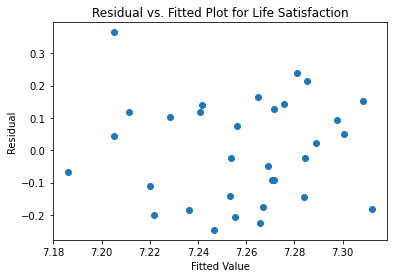



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST UNEMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     43.73
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.55e-07
Time:                        23:39:34   Log-Likelihood:                 27.926
No. Observations:                  32   AIC:                            -51.85
Df Residuals:                      30   BIC:                            -48.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

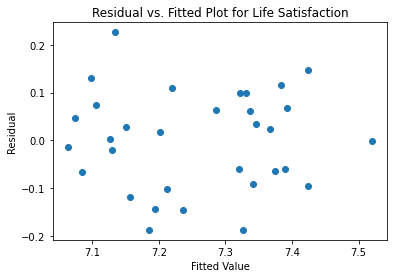



PERFORMING REGRESSION OF LIFE SATISFACTION AGAINST EMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.050
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0199
Time:                        23:39:34   Log-Likelihood:                 16.478
No. Observations:                  32   AIC:                            -28.96
Df Residuals:                      30   BIC:                            -26.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

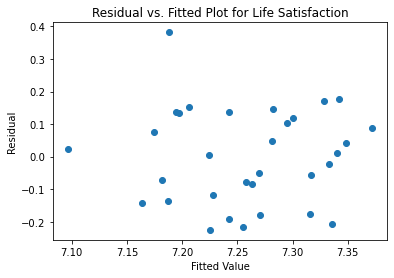



PERFORMING REGRESSION OF WORTHWHILE AGAINST ECON_INACTIVE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.988
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0550
Time:                        23:39:34   Log-Likelihood:                 14.034
No. Observations:                  32   AIC:                            -24.07
Df Residuals:                      30   BIC:                            -21.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

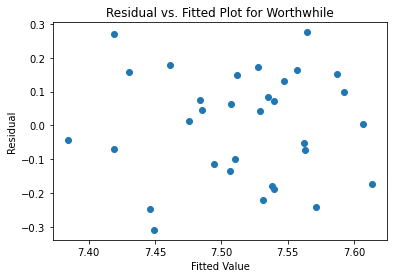



PERFORMING REGRESSION OF WORTHWHILE AGAINST UNEMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     14.72
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000597
Time:                        23:39:34   Log-Likelihood:                 18.424
No. Observations:                  32   AIC:                            -32.85
Df Residuals:                      30   BIC:                            -29.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

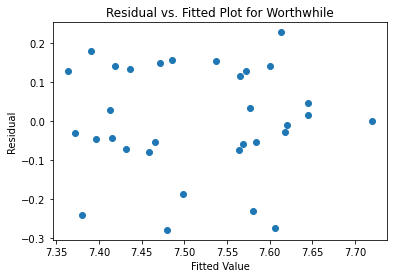



PERFORMING REGRESSION OF WORTHWHILE AGAINST EMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     8.855
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00573
Time:                        23:39:35   Log-Likelihood:                 16.175
No. Observations:                  32   AIC:                            -28.35
Df Residuals:                      30   BIC:                            -25.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

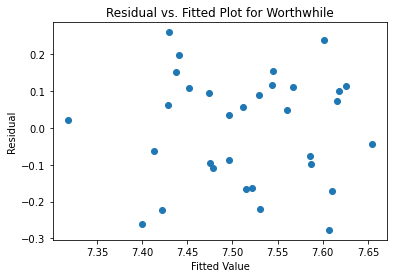



PERFORMING REGRESSION OF HAPPINESS AGAINST ECON_INACTIVE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2704
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.607
Time:                        23:39:35   Log-Likelihood:                 18.711
No. Observations:                  32   AIC:                            -33.42
Df Residuals:                      30   BIC:                            -30.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

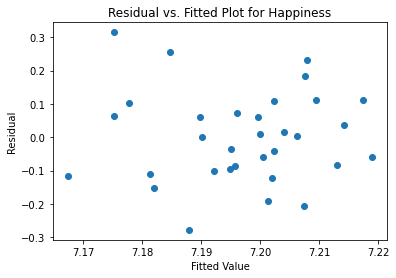



PERFORMING REGRESSION OF HAPPINESS AGAINST UNEMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.41
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000332
Time:                        23:39:35   Log-Likelihood:                 25.548
No. Observations:                  32   AIC:                            -47.10
Df Residuals:                      30   BIC:                            -44.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

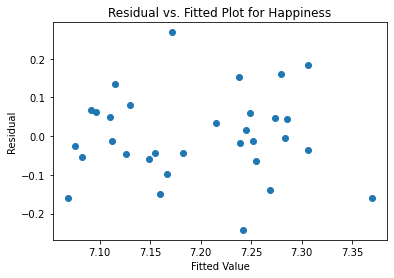



PERFORMING REGRESSION OF HAPPINESS AGAINST EMPLOYED
Outliers: []
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.266
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.143
Time:                        23:39:35   Log-Likelihood:                 19.732
No. Observations:                  32   AIC:                            -35.46
Df Residuals:                      30   BIC:                            -32.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

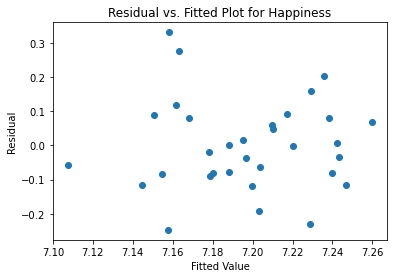

In [29]:
# Merge data
data = pd.merge(wellbeing, economic, on = 'Area')

# Groups in control
ind_var = economic.columns.tolist()[1:]

# Perform regression
for cat in wellbeing_cols:
    for group in ind_var:
        print(f'PERFORMING REGRESSION OF {cat.upper()} AGAINST {group.upper()}')

        # Remove outliers first
        df = data[['Area', cat, group]]
        data_reout, outliers_area = re_outliers_paired(df, [cat, group])
        print('Outliers:', format(outliers_area))

        # Perform regression
        reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[group])).fit()
        #reg_model = back_regress(data_reout[cat], data_reout[group])
        print(reg_model.summary())

        # plot residual vs. fit
        plt.scatter(reg_model.fittedvalues, reg_model.resid)
        plt.xlabel('Fitted Value')
        plt.ylabel('Residual')
        plt.title('Residual vs. Fitted Plot for ' + cat.title())
        plt.show()
        print('\n')